<div style="display: flex; align-items: center;">
    <img alt="udeA logo" height="140px" src="https://github.com/freddyduitama/images/blob/master/logo.png?raw=true" style="width:107px;height:152px; margin-right: 40px;">
    <div style="text-align: center;">
        <h1><b><font color='0B5345'>Proyecto 2: Análisis de señales ECG</font></b></h1>
        <h2><font color='0B5345'>Proyecto 2024-02</font></h2>
        <h3><font color='0B5345'>Luisa Fernanda Enciso - Jader Stalyn Chingal Atis</font></h3>
    </div>
</div>

In [363]:
import warnings
warnings.filterwarnings('ignore')

In [364]:
import pandas as pd
import scipy.signal as signal
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import random

<hr>

Extracción de los registros que corresponden a bradicardia sinusal (SB Sinus Bradycardia) y fibrilación auricular (AFIB Atrial Fibrillation). 




In [365]:
# Cargar el archivo Excel en un DataFrame
ruta='Diagnostics.xlsx'
diagnostics_df = pd.read_excel(ruta)

# Crear el nuevo dataframe filtrando por la columna 'Rhythm'
datos = diagnostics_df[(diagnostics_df['Rhythm'] == 'SB') | (diagnostics_df['Rhythm'] == 'AFIB')]

# Discriminar datos de acuerdo a su caracteristica 
datos_SB = diagnostics_df[(diagnostics_df['Rhythm'] == 'SB')]
datos_AFIB = diagnostics_df[(diagnostics_df['Rhythm'] == 'AFIB')]

# Convertir la columna 'FileName' en una lista de Python
datos_lista = datos['FileName'].tolist()

datos_lista_SB = datos_SB['FileName'].tolist()
datos_lista_AFIB = datos_AFIB['FileName'].tolist()

datos.head()

,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,MUSE_20180112_073319_29000,SB,TWC,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431
3,MUSE_20180113_121940_44000,SB,NONE,66,MALE,53,53,96,456,427,34,3,9,219,267,447
5,MUSE_20180112_120347_79000,SB,NONE,46,FEMALE,57,57,70,404,393,38,24,9,225,260,427
6,MUSE_20180114_075026_69000,AFIB,TWC,80,FEMALE,98,86,74,360,459,69,83,17,215,252,395


In [366]:
# Imprimir los tamaños de las listas
print(f"Tamaño total de Datos (SB + AFIB): {len(datos_lista)}")
print(f"Tamaño de (SB): {len(datos_lista_SB)}")
print(f"Tamaño de (AFIB): {len(datos_lista_AFIB)}")

Tamaño total de Datos (SB + AFIB): 5669
Tamaño de (SB): 3889
Tamaño de (AFIB): 1780


In [367]:
print(datos_lista_SB)
print(datos_lista_AFIB)

['MUSE_20180112_073319_29000', 'MUSE_20180113_121940_44000', 'MUSE_20180112_120347_79000', 'MUSE_20180114_075128_92000', 'MUSE_20180118_174026_42000', 'MUSE_20180115_125443_25000', 'MUSE_20180113_134825_04000', 'MUSE_20180114_070718_20000', 'MUSE_20180115_133559_70000', 'MUSE_20180113_071734_35000', 'MUSE_20180114_121218_64000', 'MUSE_20180113_075301_94000', 'MUSE_20180114_122918_82000', 'MUSE_20180118_135246_80000', 'MUSE_20180118_132124_94000', 'MUSE_20180118_134426_93000', 'MUSE_20180116_130527_79000', 'MUSE_20180113_131417_18000', 'MUSE_20180116_124959_22000', 'MUSE_20180116_132201_77000', 'MUSE_20180115_124515_42000', 'MUSE_20180114_072951_09000', 'MUSE_20180113_175348_27000', 'MUSE_20180119_171326_67000', 'MUSE_20180115_121230_14000', 'MUSE_20180113_130248_31000', 'MUSE_20180116_130424_37000', 'MUSE_20180114_072023_07000', 'MUSE_20180116_134125_04000', 'MUSE_20180112_122435_44000', 'MUSE_20180112_073011_37000', 'MUSE_20180112_073537_11000', 'MUSE_20180118_125813_14000', 'MUSE_201

<hr>

<h3><strong>Promedio de datos</strong></h3>


In [368]:
# Ruta donde están almacenados los archivos .csv
ruta = r"C:\Users\luisa\Downloads\ECGDataDenoised\ECGDataDenoised"

# Nombres de las columnas esperadas en los archivos CSV
columnas = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

# Inicializar listas para almacenar las señales de la derivación II
derivacion_II_SB = []
derivacion_II_AFIB = []

# Función para extraer datos de la derivación II para los sujetos
def extraer_derivacion_II(datos_lista, lista_destino):
    for sujeto in datos_lista:
        file_path = os.path.join(ruta, f"{sujeto}.csv")  # Crear ruta completa del archivo
        if os.path.exists(file_path):
            # Leer el archivo CSV y extraer la columna 'II'
            df = pd.read_csv(file_path, delimiter=',', names=columnas)
            signal = df['II'].to_numpy()  # Almacenar como un array de numpy
            
            # Rellenar con ceros si la longitud es menor que 5000
            if signal.shape[0] < 5000:
                padding = 5000 - signal.shape[0]
                signal = np.pad(signal, (0, padding), 'constant')  # Rellenar con ceros al final
            
            # Asegurarse de que la longitud sea exactamente 5000
            assert signal.shape[0] == 5000, f"Error inesperado: La señal para {sujeto} tiene una longitud de {signal.shape[0]}"
            lista_destino.append(signal)
        else:
            print(f"Advertencia: No se encontró el archivo {sujeto}.csv en la carpeta especificada.")

# Extraer datos de la derivación II para SB y AFIB
extraer_derivacion_II(datos_lista_SB, derivacion_II_SB)
extraer_derivacion_II(datos_lista_AFIB, derivacion_II_AFIB)

# Comprobar el número de señales extraídas
print(f"Número de sujetos para SB: {len(derivacion_II_SB)}")
print(f"Número de sujetos para AFIB: {len(derivacion_II_AFIB)}")

# Promediar punto a punto
promedio_SB = np.mean(derivacion_II_SB, axis=0) if derivacion_II_SB else None
promedio_AFIB = np.mean(derivacion_II_AFIB, axis=0) if derivacion_II_AFIB else None

# Comprobar si se calcularon los promedios
if promedio_SB is not None:
    print(f"Forma del promedio de la derivación II para SB: {promedio_SB.shape}")
else:
    print("No se pudieron calcular los promedios para SB.")

if promedio_AFIB is not None:
    print(f"Forma del promedio de la derivación II para AFIB: {promedio_AFIB.shape}")
else:
    print("No se pudieron calcular los promedios para AFIB.")

Número de sujetos para SB: 3889
Número de sujetos para AFIB: 1780
Forma del promedio de la derivación II para SB: (5000,)
Forma del promedio de la derivación II para AFIB: (5000,)


* Funcion para graficar

In [369]:
# Graficar la señal original y la señal después de aplicar detrending en la disposición deseada
def graficar_signales(promedio_SB,titulo1, detrended_SB, titulo2,promedio_AFIB, titulo3,detrended_AFIB,titulo4):
    plt.figure(figsize=(10, 8))

    # Graficar promedio SB (Original)
    if promedio_SB is not None:
        plt.subplot(2, 2, 1)  # Primera fila, primera columna
        plt.plot(promedio_SB, color='#8babf1', label='SB')
        plt.title(titulo1)
        plt.xlabel('Muestras')
        plt.ylabel('Amplitud')
        plt.legend()

    # Graficar detrended SB (Detrended)
    if detrended_SB is not None:
        plt.subplot(2, 2, 3)  # Primera fila, segunda columna
        plt.plot(detrended_SB, color='#0073e6', label='SB')
        plt.title(titulo2)
        plt.xlabel('Muestras')
        plt.ylabel('Amplitud')
        plt.legend()

    # Graficar promedio AFIB (Original)
    if promedio_AFIB is not None:
        plt.subplot(2, 2, 2)  # Segunda fila, primera columna
        plt.plot(promedio_AFIB, color='#8babf1', label='AFIB')
        plt.title(titulo3)
        plt.xlabel('Muestras')
        plt.ylabel('Amplitud')
        plt.legend()

    # Graficar detrended AFIB (Detrended)
    if detrended_AFIB is not None:
        plt.subplot(2, 2, 4)  # Segunda fila, segunda columna
        plt.plot(detrended_AFIB, color='#0073e6', label='AFIB')
        plt.title(titulo4)
        plt.xlabel('Muestras')
        plt.ylabel('Amplitud')
        plt.legend()

    plt.tight_layout()
    plt.show()

<hr>
3. De estos registros los análisis para el presente proyecto deben hacerse en la
   derivación II

    Programar las fórmulas 1 al 4 que se encuentran en el artículo (15%). Consultar que significado y utilidad del biespectro (Realice la gráfica) (5%)

<hr>

<h3><strong>Ecuación 1: Detrending</strong></h3>

In [370]:
from scipy.signal import detrend
def detrending(signals):
    detrended_signals = detrend(signals, axis=0)
    return detrended_signals

* Probar Función detrending

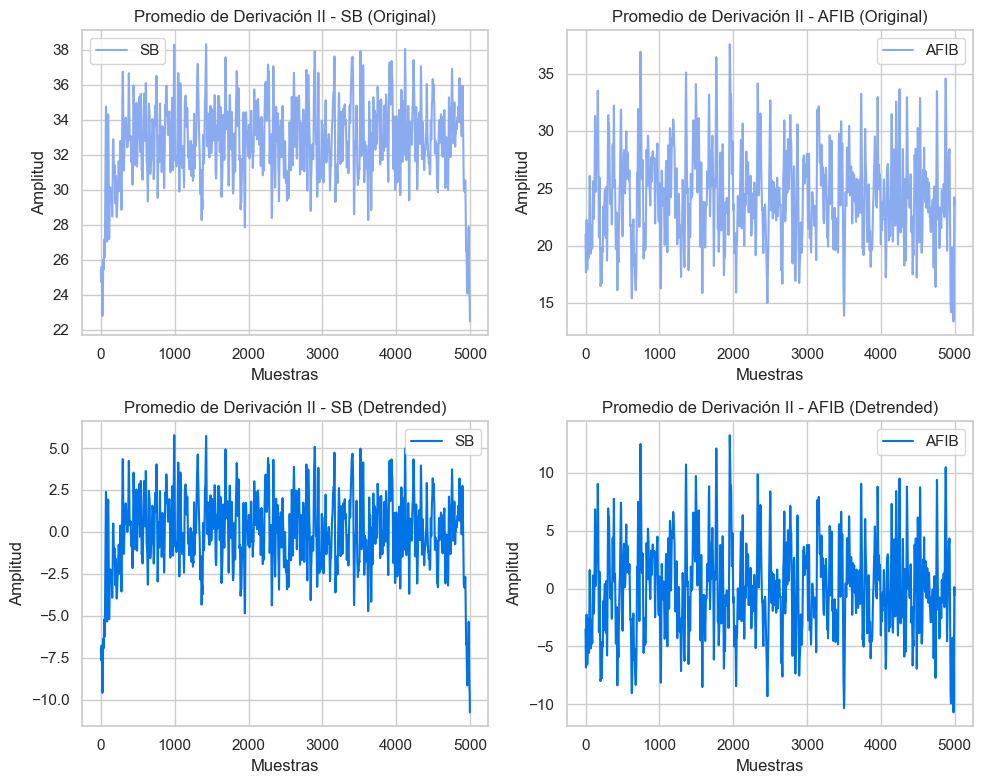

In [371]:
# Aplicar detrending a los promedios
detrended_SB = detrending(promedio_SB) if promedio_SB is not None else None
detrended_AFIB = detrending(promedio_AFIB) if promedio_AFIB is not None else None

titulo1 = 'Promedio de Derivación II - SB (Original)'
titulo2 = 'Promedio de Derivación II - SB (Detrended)'
titulo3 = 'Promedio de Derivación II - AFIB (Original)'
titulo4 = 'Promedio de Derivación II - AFIB (Detrended)'

# Llamar a la función de graficar
graficar_signales(promedio_SB,titulo1, detrended_SB,titulo2, promedio_AFIB, titulo3,detrended_AFIB,titulo4)

<hr>

<h3><strong>Ecuación 2: Compression</strong></h3>

In [372]:
def compression(timeseries: np.ndarray) -> np.ndarray:
  """
    Normaliza la señal recibida, poniendola entre 0 y 1.
  """
  max = timeseries.max()
  min = timeseries.min()
  
  # Aplicar la normalización min-max
  return (timeseries - min) / (max - min)

* Probar Función compression

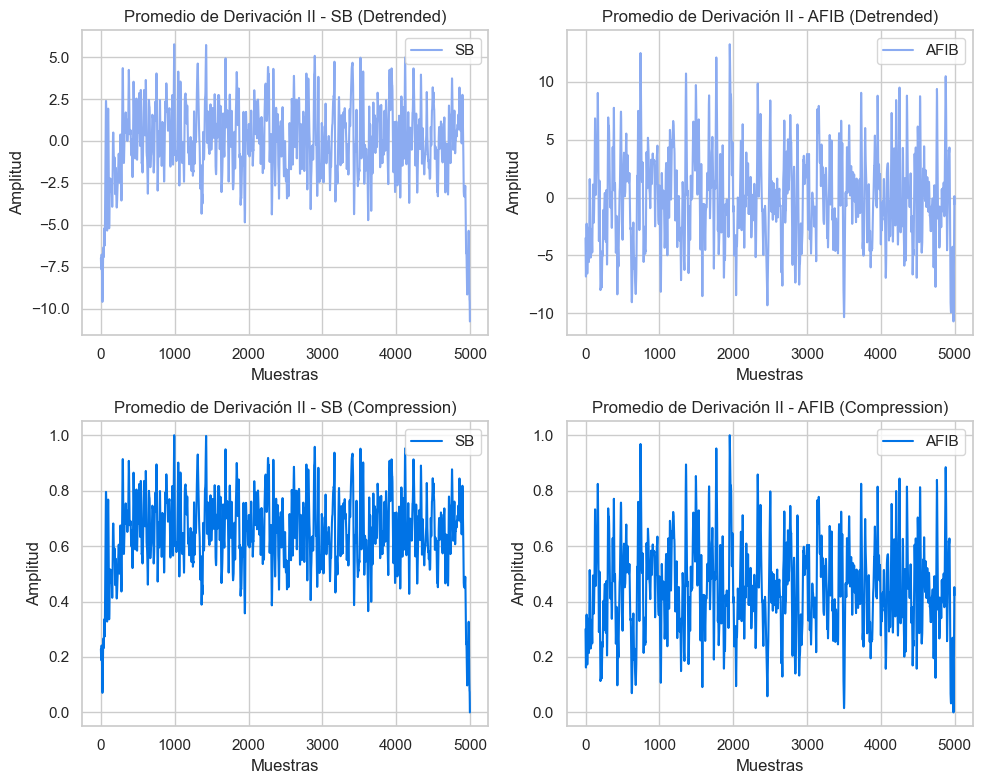

In [373]:
# Aplicar compresión a las señales detrended
compressed_SB = compression(detrended_SB) if detrended_SB is not None else None
compressed_AFIB = compression(detrended_AFIB) if detrended_AFIB is not None else None

titulo1 = 'Promedio de Derivación II - SB (Detrended)'
titulo2 = 'Promedio de Derivación II - SB (Compression)'
titulo3 = 'Promedio de Derivación II - AFIB (Detrended)'
titulo4 = 'Promedio de Derivación II - AFIB (Compression)'

# Llamar a la función de graficar
graficar_signales(detrended_SB,titulo1, compressed_SB,titulo2, detrended_AFIB, titulo3,compressed_AFIB,titulo4)

* Hacer Detrend nuevamente

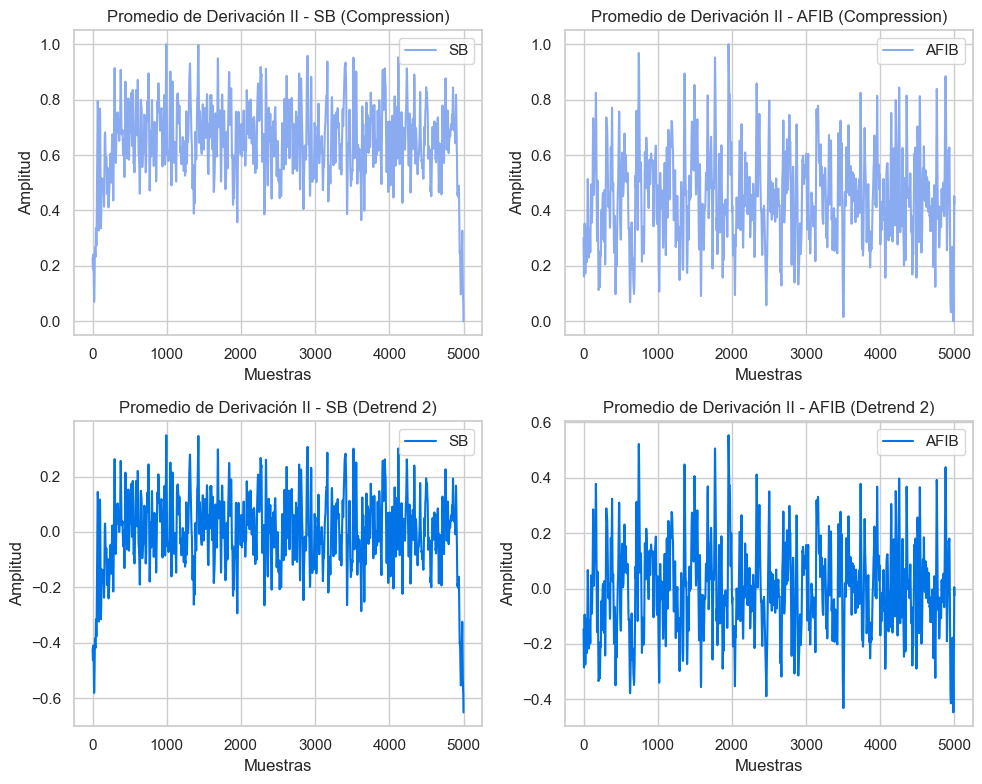

In [374]:
# Aplicar compresión a las señales detrended
detrended_SB_2 = detrending(compressed_SB) if compressed_SB is not None else None
detrended_AFIB_2 = detrending(compressed_AFIB) if compressed_AFIB is not None else None

titulo1 = 'Promedio de Derivación II - SB (Compression)'
titulo2 = 'Promedio de Derivación II - SB (Detrend 2)'
titulo3 = 'Promedio de Derivación II - AFIB (Compression)'
titulo4 = 'Promedio de Derivación II - AFIB (Detrend 2)'

# Llamar a la función de graficar
graficar_signales(compressed_SB,titulo1, detrended_SB_2,titulo2, compressed_AFIB, titulo3,detrended_AFIB_2,titulo4)

<hr>

<h3><strong>Ecuación 3 y 4: Bispectrum and Bicoherence</strong></h3>

In [375]:
def BispectrumAndBicoherencia(signal: np.ndarray, sampling_frequency: int, nfft: int) -> np.ndarray:
    """
    Calcula el bispectro y la bicoherencia de una señal.

    Parameters:
    signal (np.ndarray): Señal de entrada para el cálculo.
    sampling_frequency (int): Frecuencia de muestreo de la señal.
    nfft (int): Número de puntos para la Transformada Rápida de Fourier (FFT).

    Returns:
    np.ndarray: Matriz del bispectro simétrico.
    """
    # Inicializar la lista para almacenar segmentos de la señal
    segments = []

    # Calcular los índices de los segmentos de la señal
    segment_indices = range(0, len(signal) - nfft + 1, nfft)

    # Extraer segmentos de la señal
    for index in segment_indices:
        segment = signal[index:index + nfft]
        segments.append(segment)

    # Convertir la lista de segmentos a un array NumPy
    segments = np.array(segments)
    num_segments = segments.shape[0]

    # Calcular la FFT de los segmentos
    fft_segments = np.fft.fft(segments, n=nfft, axis=1)
    fft_segments = fft_segments[:, :nfft // 2]  # Tomar solo la mitad positiva de la FFT

    # Inicializar matrices para el bispectro y bicoherencia
    bispectrum = np.zeros((nfft // 2, nfft // 2), dtype=complex)
    bispectrum_magnitude = np.zeros((nfft // 2, nfft // 2), dtype=complex)

    # Calcular el bispectro
    for k in range(num_segments):
        segment_fft = fft_segments[k, :]
        for frequency1 in range(nfft // 2):
            for frequency2 in range(frequency1, nfft // 2 - frequency1):  # Aplicar simetría
                frequency3 = frequency1 + frequency2
                if frequency3 < nfft // 2:  # Asegurarse de que frequency3 no exceda los límites
                    bispectrum[frequency1, frequency2] += segment_fft[frequency1] * segment_fft[frequency2] * np.conj(segment_fft[frequency3])
                    bispectrum_magnitude[frequency1, frequency2] += np.abs(segment_fft[frequency1] * segment_fft[frequency2] * np.conj(segment_fft[frequency3]))

    # Normalización del bispectro
    bispectrum = np.abs(bispectrum) / bispectrum_magnitude

    # Aplicar simetría a la matriz del bispectro
    symmetric_bispectrum = np.zeros((nfft // 2, nfft // 2))
    for frequency1 in range(nfft // 2):
        for frequency2 in range(frequency1, nfft // 2 - frequency1):
            symmetric_bispectrum[frequency1, frequency2] = bispectrum[frequency1, frequency2]

    return symmetric_bispectrum  # Retornar el bispectro simétrico


def Symmetrize(bicoherence: np.ndarray) -> np.ndarray:
    """
    Aplica simetría a la bicoherencia.

    Parameters:
    bicoherence (np.ndarray): Matriz de bicoherencia para aplicar simetría.

    Returns:
    np.ndarray: Matriz de bicoherencia simétrica.
    """
    symmetric_bicoherence = np.zeros((10, 20))
    for frequency1 in range(20):
        for frequency2 in range(frequency1, 20 - frequency1):
            symmetric_bicoherence[frequency1, frequency2] = bicoherence[frequency1, frequency2]
    return symmetric_bicoherence


* Probar la Bicoherencia para un solo sujeto

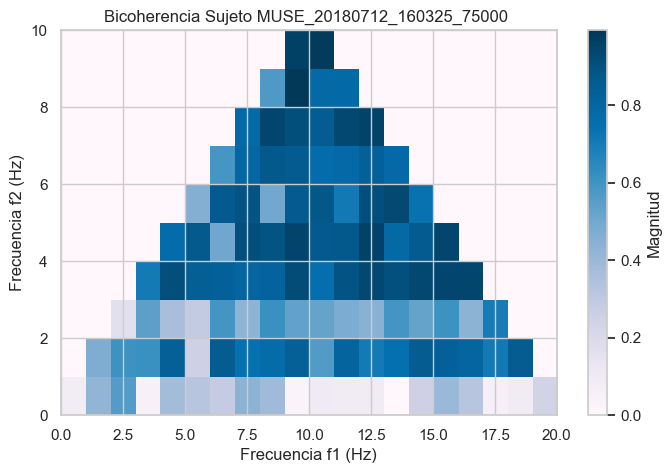

In [376]:
# Cargar la señal desde el archivo CSV
ruta = r"C:\Users\luisa\Downloads\MUSE_20180712_160325_75000.csv"
signal = detrending(compression(detrending(pd.read_csv(ruta, delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])['II'])))


# Definir la frecuencia de muestreo y el tamaño de la FFT
fs = 10  # Frecuencia de muestreo
nfft = 500  # Tamaño de la FFT

# Calcular el bispectro
bispectrum = BispectrumAndBicoherencia(signal, fs, nfft)

bispectrum= Symmetrize(bispectrum)
# Graficar el bispectro
plt.figure(figsize=(8, 5))
plt.imshow(np.abs(bispectrum), extent=(0, 20, 0, 10), aspect='auto', origin='lower', cmap='PuBu')
plt.colorbar(label='Magnitud')
plt.xlabel('Frecuencia f1 (Hz)')
plt.ylabel('Frecuencia f2 (Hz)')
plt.title('Bicoherencia Sujeto MUSE_20180712_160325_75000 ')
plt.show()

* Probar la Bicoherencia para el promedio de sujetos con patologías estudiadas

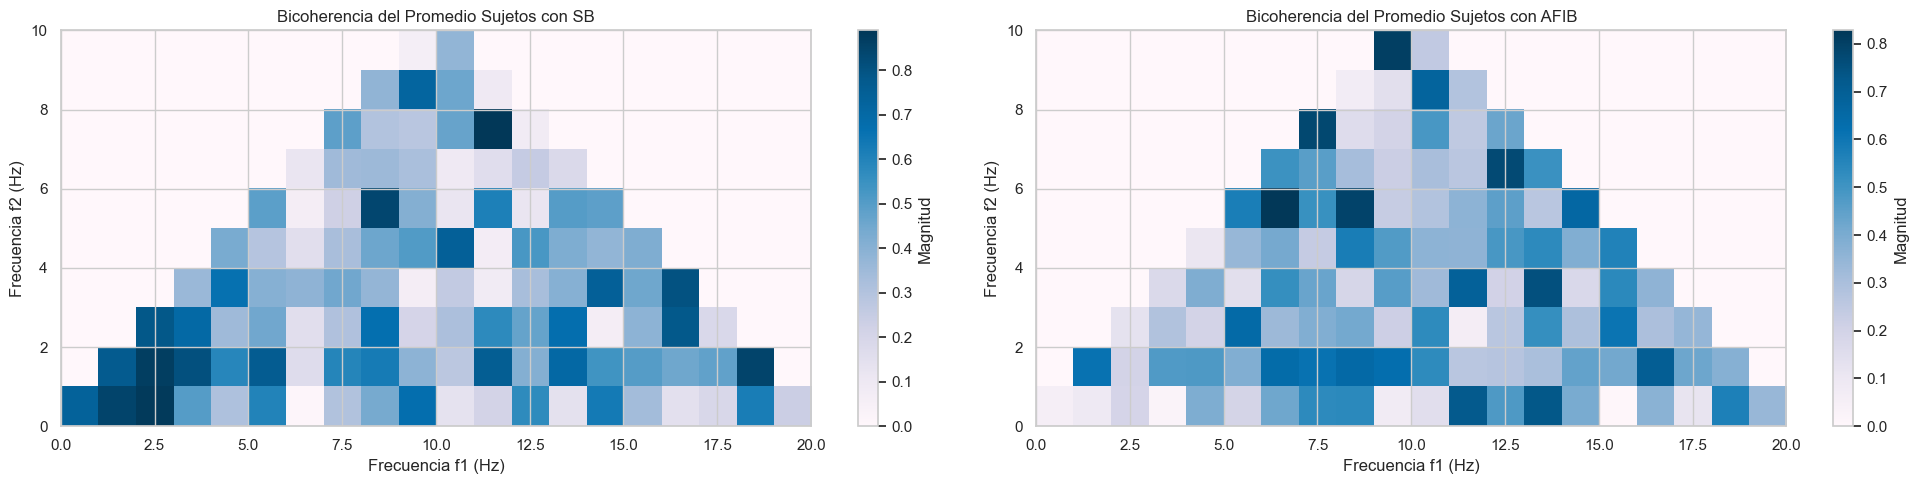

In [377]:
# Definir la frecuencia de muestreo y el tamaño de la FFT
fs = 10  # Frecuencia de muestreo
nfft = 500  # Tamaño de la FFT

# Señales
signal1 = detrended_SB_2
signal2 = detrended_AFIB_2

# Calcular el bispectro de las dos señales
bispectrum1 = BispectrumAndBicoherencia(signal1, fs, nfft)
bispectrum1 = Symmetrize(bispectrum1)

bispectrum2 = BispectrumAndBicoherencia(signal2, fs, nfft)
bispectrum2 = Symmetrize(bispectrum2)

# Crear la figura con dos subplots en una fila
plt.figure(figsize=(20, 5))

# Primer subplot para signal1
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, 1er subplot
plt.imshow(np.abs(bispectrum1), extent=(0, 20, 0, 10), aspect='auto', origin='lower', cmap='PuBu')
plt.colorbar(label='Magnitud')
plt.xlabel('Frecuencia f1 (Hz)')
plt.ylabel('Frecuencia f2 (Hz)')
plt.title('Bicoherencia del Promedio Sujetos con SB')

# Segundo subplot para signal2
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, 2do subplot
plt.imshow(np.abs(bispectrum2), extent=(0, 20, 0, 10), aspect='auto', origin='lower', cmap='PuBu')
plt.colorbar(label='Magnitud')
plt.xlabel('Frecuencia f1 (Hz)')
plt.ylabel('Frecuencia f2 (Hz)')
plt.title('Bicoherencia del Promedio Sujetos con AFIB')

# Mostrar el gráfico
plt.tight_layout()  # Ajustar el espaciado entre subplots
plt.show()


<hr>

4. Para cada señal extraer la frecuencia que contiene la máxima potencia y Gráfiquela (15%)

In [378]:
def powerSpectrum(signal: np.ndarray) -> dict:
    # Calcular la FFT
    FT = np.fft.fft(signal)
    FT = np.abs(FT[:len(FT)//2])  # Tomar solo la mitad positiva
    freqs = np.fft.fftfreq(len(signal), 1/500)
    freqs = freqs[:len(freqs)//2]  # Frecuencias correspondientes
    power = np.abs(FT)**2  # Potencia de la FFT
    maxV = np.argmax(power)  # Índice del valor máximo
    maxFf = round(freqs[maxV], 5)  # Frecuencia máxima
    maxP = power[maxV]  # Potencia máxima
    maxF = FT[maxV]  # Valor de la FFT en la frecuencia máxima

    # Retornar los resultados
    return {
        'frequencies': freqs,
        'FFT': FT,
        'max_frequency': maxFf,
        'max_power': maxP,
        'max_value': maxF,
    }

* Probar las Frecuencias maximas para promedio de sujetos con Patología

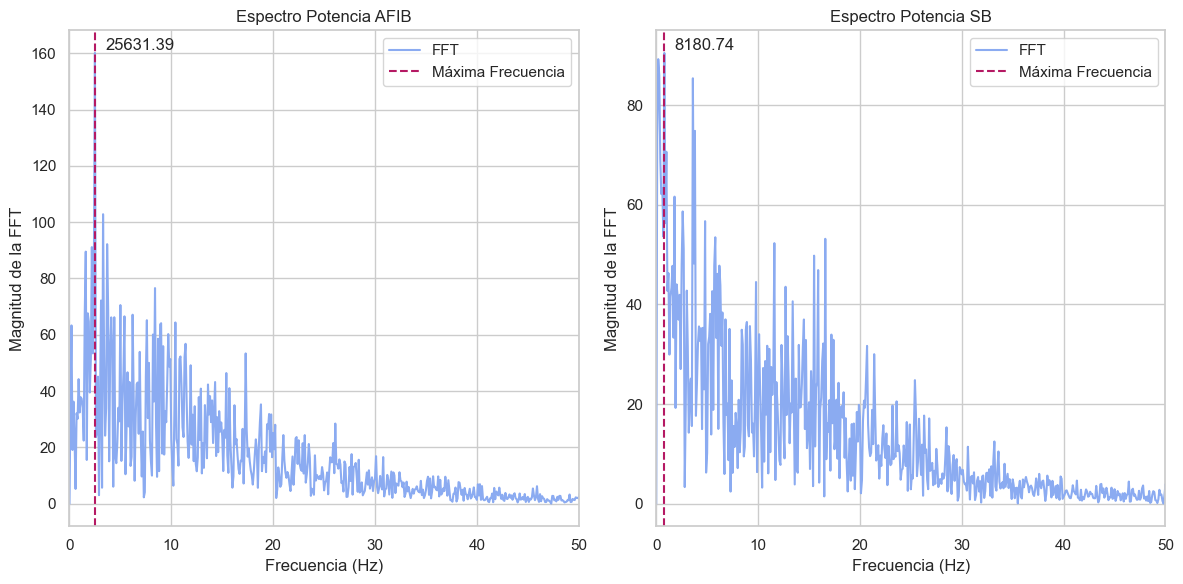

Máxima Frecuencia para AFIB: 2.5 Hz
Máxima Frecuencia para SB: 0.8 Hz


In [379]:
# Extraer la máxima frecuencia de ambas señales
result_AFIB = powerSpectrum(detrended_AFIB_2)
result_SB = powerSpectrum(detrended_SB_2)

# Graficar para Detrended AFIB
plt.figure(figsize=(12, 6))

for i, result in enumerate([result_AFIB, result_SB]):
    plt.subplot(1, 2, i + 1)
    plt.plot(result['frequencies'], result['FFT'], label='FFT', color='#8babf1')
    plt.axvline(result['max_frequency'], color='#b51963', linestyle='--', label='Máxima Frecuencia')

    # Ajustar la posición del texto para evitar superposición
    plt.text(result['max_frequency'] + 1, result['max_value'] + 0.05, 
             f'{result["max_power"]:.2f}',  # Puedes ajustar el desplazamiento como desees
             verticalalignment='bottom', horizontalalignment='left')

    # Asignar títulos específicos a cada subgráfico
    if i == 0:
        plt.title('Espectro Potencia AFIB')
    else:
        plt.title('Espectro Potencia SB')

    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Magnitud de la FFT')
    plt.xlim(0, 50)  # Limitar el eje X hasta 50 Hz
    plt.legend()

plt.tight_layout()
plt.show()

# Mostrar los resultados de la máxima frecuencia
print(f'Máxima Frecuencia para AFIB: {result_AFIB["max_frequency"]} Hz')
print(f'Máxima Frecuencia para SB: {result_SB["max_frequency"]} Hz')



<hr>

5. Para cada señal sumar el número de frecuencias que son significativas para bicoherencia (20%)

In [380]:
def count_significant_frequencies(bicoherence: np.ndarray, N: int) -> int:
    """
    Cuenta el número de frecuencias significativas para bicoherencia.
    
    Args:
    - bicoherence (np.ndarray): Matriz de bicoherencia calculada.
    - N (int): Número de segmentos utilizados en el cálculo de la bicoherencia.
    
    Returns:
    - int: Número de frecuencias significativas.
    """
    # Calcular el umbral
    threshold = np.sqrt(9.2 / (2 * N))
    
    # Contar cuántas frecuencias son mayores que el umbral
    significant_count = np.sum(bicoherence > threshold)
    
    return significant_count

* Probar función en el promedio de sujetos con patología

In [381]:
# Señales
signal_SB = bispectrum1
signal_AFIB = bispectrum2
N = 500

# Contar las frecuencias significativas
SB_significant_frequencies = count_significant_frequencies(signal_SB, N)
AFIB_significant_frequencies = count_significant_frequencies(signal_AFIB, N)

# Mostrar información
print(f"Número de frecuencias significativas para SB: {SB_significant_frequencies}")
print(f"Número de frecuencias significativas para AFIB: {AFIB_significant_frequencies}")

Número de frecuencias significativas para SB: 100
Número de frecuencias significativas para AFIB: 103


<hr>

6. Crear una rutina que aplique sobre todos los archivos de la base de datos las rutina 3 al 5 y almacene los resultados en un dataframe donde se pueda registro, tipo de patología y el frecuencia de máxima potencia (fMP) y suma de frecuencias significativas en bicoherencia (sFSB):

In [382]:
# DataFrame para almacenar los resultados
results_df = pd.DataFrame(columns=['Estado', 'fMP', 'sFSB'])

# Nuevo DataFrame para almacenar las estadísticas descriptivas
stats_df = pd.DataFrame(columns=['Estado', 'Media', 'Mediana', 'Desviación'])

def extract_signal_data(file_list: list[str]):
    processed_count = 0

    for file_name in file_list:
        try:
            # Obtener la fila correspondiente del DataFrame de diagnósticos
            diagnosis_row = diagnostics_df[diagnostics_df.FileName == file_name.split('.')[0]]
            # Verificar que exista la fila y obtener los valores
            if not diagnosis_row.empty:
                diagnosis_name = diagnosis_row.FileName.to_numpy()[0]
                pathology = diagnosis_row.Rhythm.to_numpy()[0]
                
                # Filtrar solo los ritmos de interés
                if pathology in ['SB', 'AFIB']:
                    # Procesar cada archivo CSV
                    signal_data = detrending(compression(detrending(pd.read_csv(os.path.join(ruta, file_name), 
                                                                            names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])['II'])))

                    # Calcular estadísticas descriptivas del bicoherence
                    media = np.mean(signal_data)
                    mediana = np.median(signal_data)
                    desviacion = np.std(signal_data)

                    # Obtener máxima frecuencia
                    max_frequency = powerSpectrum(signal_data)["max_frequency"]

                    # Obtener bicoherencia y conteo de frecuencias significativas
                    bicoherence = BispectrumAndBicoherencia(signal_data, 10, 500)
                    simetria = Symmetrize(bicoherence)
                    significant_freq_count =np.sum(simetria>0.095)

                    # Almacenar resultados en el DataFrame de resultados
                    result = {
                        'Estado': pathology,
                        'fMP': max_frequency,  
                        'sFSB': significant_freq_count 
                    }
                    results_df.loc[diagnosis_name] = result

                    # Almacenar estadísticas en el DataFrame de estadísticas descriptivas
                    stats_result = {
                        'Estado': pathology,
                        'Media': media,
                        'Mediana': mediana,
                        'Desviación': desviacion
                    }
                    stats_df.loc[diagnosis_name] = stats_result

                    processed_count += 1
                    print(f'Procesados: {processed_count}')  # Mostrar cuántos han sido procesados

        except Exception as e:
            print(f'Error procesando {file_name}: {e}')

    return results_df, stats_df


<hr>

7. Para las señales de análisis del punto 2 aplicar las rutinas del punto 3 al 5 y hacer un informe que permita evidenciar las diferencias entre las señales SB y AFIB utilizando las herramientas de estadística descriptiva (5%)

In [383]:
# Establecer la ruta y cargar los archivos
ruta = r"C:\Users\luisa\Downloads\ECGDataDenoised\ECGDataDenoised"
file_list = os.listdir(ruta)

# Ejecutar la función
results_df, stats_df = extract_signal_data(file_list)

Procesados: 1
Procesados: 2
Procesados: 3
Procesados: 4
Procesados: 5
Procesados: 6
Procesados: 7
Procesados: 8
Procesados: 9
Procesados: 10
Procesados: 11
Procesados: 12
Procesados: 13
Procesados: 14
Procesados: 15
Procesados: 16
Procesados: 17
Procesados: 18
Procesados: 19
Procesados: 20
Procesados: 21
Procesados: 22
Procesados: 23
Procesados: 24
Procesados: 25
Procesados: 26
Procesados: 27
Procesados: 28
Procesados: 29
Procesados: 30
Procesados: 31
Procesados: 32
Procesados: 33
Procesados: 34
Procesados: 35
Procesados: 36
Procesados: 37
Procesados: 38
Procesados: 39
Procesados: 40
Procesados: 41
Procesados: 42
Procesados: 43
Procesados: 44
Procesados: 45
Procesados: 46
Procesados: 47
Procesados: 48
Procesados: 49
Procesados: 50
Procesados: 51
Procesados: 52
Procesados: 53
Procesados: 54
Procesados: 55
Procesados: 56
Procesados: 57
Procesados: 58
Procesados: 59
Procesados: 60
Procesados: 61
Procesados: 62
Procesados: 63
Procesados: 64
Procesados: 65
Procesados: 66
Procesados: 67
Proc

* Caracterización por patología

In [384]:
results_df.head()

,Estado,fMP,sFSB
MUSE_20180111_155154_74000,AFIB,9.7,104
MUSE_20180111_155203_15000,AFIB,2.7,108
MUSE_20180111_155758_17000,SB,3.7,109
MUSE_20180111_155839_67000,SB,2.9,102
MUSE_20180111_155859_36000,SB,2.8,102


In [385]:
stats_df.head()

,Estado,Media,Mediana,Desviación
MUSE_20180111_155154_74000,AFIB,3.224976e-16,-0.030115,0.125835
MUSE_20180111_155203_15000,AFIB,1.080025e-16,-0.031761,0.120065
MUSE_20180111_155758_17000,SB,6.625811e-17,-0.029410,0.112125
MUSE_20180111_155839_67000,SB,1.628031e-16,-0.023894,0.094712
MUSE_20180111_155859_36000,SB,1.486811e-16,-0.032635,0.130293


In [386]:
print(results_df.shape)
print(stats_df.shape)

resultados_finales = results_df
estadistica_final = stats_df

(5669, 3)
(5669, 4)


<hr>
<h3><strong>Estadistica</strong></h3>

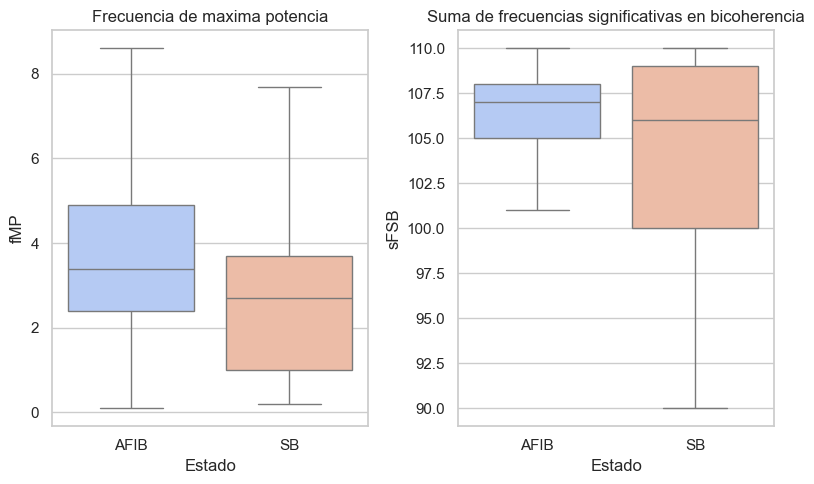

In [387]:
import seaborn as sns

# Establecer estilo de fondo blanco con grid y paleta de colores
sns.set(style="whitegrid")
palette = "coolwarm"

# Crear un boxplot para la columna 'fMP' y 'sFSB', agrupado por 'Estado'
plt.figure(figsize=(8, 5))

# Boxplot para 'fMP'
plt.subplot(1, 2, 1)  # Crear un subplot 1x2 y el primer gráfico
sns.boxplot(x='Estado', y='fMP', data=results_df, palette=palette,showfliers=False)
plt.title('Frecuencia de maxima potencia')
plt.ylabel('fMP')

# Boxplot para 'sFSB'
plt.subplot(1, 2, 2)  # Crear el segundo gráfico
sns.boxplot(x='Estado', y='sFSB', data=results_df, palette=palette,showfliers=False)
plt.title('Suma de frecuencias significativas en bicoherencia')
plt.ylabel('sFSB')

# Mostrar los gráficos
plt.tight_layout()
plt.show()



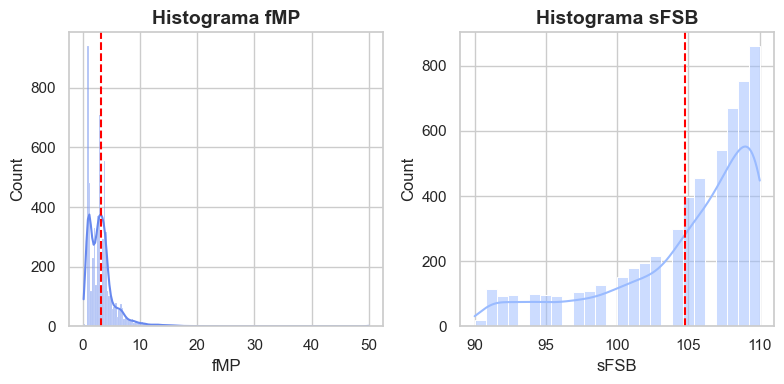

In [388]:
# Función ajustada para crear subplots de 1 fila y 2 columnas
def histplot_subplots(df, measures, titles):
    sns.set(style="whitegrid")  # Estilo de fondo blanco con grid
    palette = "coolwarm"  # Paleta de colores

    # Crear subplots de 1 fila y 2 columnas
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Iterar sobre las métricas
    for i, measure in enumerate(measures):
        # Histograma con KDE
        sns.histplot(df[measure].dropna(), kde=True, ax=axes[i], color=sns.color_palette(palette)[i])
        
        # Línea vertical en la media
        axes[i].axvline(np.mean(df[measure].dropna()), color='red', linestyle='--')
        
        # Título de cada gráfico
        axes[i].set_title(titles[i], fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Establecer las métricas y títulos
measures = ['fMP', 'sFSB']  # Columnas a graficar
titles = ['Histograma fMP', 'Histograma sFSB']  # Títulos de los gráficos

# Ejecutar la función de gráficos
histplot_subplots(results_df, measures, titles)



<hr>
<h3><strong>Estadistica inferencial</strong></h3>

* Prueba de normalidad y homocedasticidad

In [407]:
# Definir las métricas que deseas analizar
metrics = ['fMP', 'sFSB']  

# Inicializa una lista para almacenar los resultados
results = []

# Realiza pruebas para cada métrica
for metric in metrics:
    # Filtrar los datos para cada estado
    data_SB = resultados_finales[resultados_finales['Estado'] == 'SB'][metric].dropna()
    data_AFIB = resultados_finales[resultados_finales['Estado'] == 'AFIB'][metric].dropna()

    # Prueba de normalidad (Shapiro-Wilk)
    stat_normality_SB, p_value_normality_SB = stats.shapiro(data_SB)
    normality_result_SB = 'Normal' if p_value_normality_SB > 0.05 else 'No normal'

    stat_normality_AFIB, p_value_normality_AFIB = stats.shapiro(data_AFIB)
    normality_result_AFIB = 'Normal' if p_value_normality_AFIB > 0.05 else 'No normal'

    # Prueba de homocedasticidad (Levene)
    stat_homoscedasticity, p_value_homoscedasticity = stats.levene(data_SB, data_AFIB)
    homoscedasticity_result = 'Homocedástico' if p_value_homoscedasticity > 0.05 else 'Heterocedástico'

    # Agrega los resultados a la lista
    results.append({
        'Metric': metric,
        'SB Normality (p-value)': p_value_normality_SB,
        'SB Normality Result': normality_result_SB,
        'AFIB Normality (p-value)': p_value_normality_AFIB,
        'AFIB Normality Result': normality_result_AFIB,
        'Homoscedasticity (p-value)': p_value_homoscedasticity,
        'Homoscedasticity Result': homoscedasticity_result
    })

# Crea un DataFrame con los resultados
results_df_stats = pd.DataFrame(results)

# Muestra el DataFrame
results_df_stats


,Metric,SB Normality (p-value),SB Normality Result,AFIB Normality (p-value),AFIB Normality Result,Homoscedasticity (p-value),Homoscedasticity Result
0,fMP,2.716097e-70,No normal,2.780254e-46,No normal,7.739821e-21,Heterocedástico
1,sFSB,4.848194e-48,No normal,1.895683e-33,No normal,3.224818e-193,Heterocedástico


* Prueba No parametrica - U de Mann Whitnney

In [408]:
# Definir las métricas a analizar
metrics = ['fMP', 'sFSB']

# Inicializa una lista para almacenar los resultados
results = []

# Realiza pruebas para cada métrica
for metric in metrics:
    # Filtrar los datos para cada estado
    data_SB = resultados_finales[resultados_finales['Estado'] == 'SB'][metric].dropna()
    data_AFIB = resultados_finales[resultados_finales['Estado'] == 'AFIB'][metric].dropna()

    # Prueba U de Mann-Whitney
    stat, p_value = stats.mannwhitneyu(data_SB, data_AFIB)

    # Determinar si hay diferencia significativa
    significant = 'Hay diferencia Significativa' if p_value < 0.05 else 'No hay diferencia significativa'

    # Agregar los resultados a la lista
    results.append({
        'Metric': metric,
        'Mann-Whitney U (stat)': stat,
        'p-value': p_value,
        'Significance': significant
    })

# Crear un DataFrame con los resultados
results_df_2 = pd.DataFrame(results)

# Mostrar el DataFrame con los resultados
results_df_2


,Metric,Mann-Whitney U (stat),p-value,Significance
0,fMP,2141031.5,2.867017e-118,Hay diferencia Significativa
1,sFSB,2871664.5,3.842774e-25,Hay diferencia Significativa


<hr>
<h3><strong>Datos descriptivos de acuerdo con la patología</strong></h3>

In [389]:
AFIB , SB = stats_df.groupby('Estado')

In [390]:
AFIB2 , SB2 = results_df.groupby('Estado')

* Patología AFIB

In [391]:
AFIB [1]

,Estado,Media,Mediana,Desviación
MUSE_20180111_155154_74000,AFIB,3.224976e-16,-0.030115,0.125835
MUSE_20180111_155203_15000,AFIB,1.080025e-16,-0.031761,0.120065
MUSE_20180111_155903_57000,AFIB,5.069722e-16,-0.015376,0.122165
MUSE_20180111_155945_02000,AFIB,7.389644e-17,-0.029507,0.137123
MUSE_20180111_160053_89000,AFIB,6.625811e-17,-0.037776,0.123332
...,...,...,...,...
MUSE_20180712_161449_58000,AFIB,1.477929e-16,-0.004934,0.083736
MUSE_20180712_161451_72000,AFIB,1.456613e-16,-0.038985,0.131560
MUSE_20180712_161452_78000,AFIB,6.963319e-17,-0.038144,0.121440
MUSE_20180712_161503_00000,AFIB,5.453415e-17,-0.050121,0.142928


In [392]:
AFIB2 [1]

,Estado,fMP,sFSB
MUSE_20180111_155154_74000,AFIB,9.7,104
MUSE_20180111_155203_15000,AFIB,2.7,108
MUSE_20180111_155903_57000,AFIB,2.2,101
MUSE_20180111_155945_02000,AFIB,4.2,107
MUSE_20180111_160053_89000,AFIB,2.9,108
...,...,...,...
MUSE_20180712_161449_58000,AFIB,12.4,97
MUSE_20180712_161451_72000,AFIB,3.9,108
MUSE_20180712_161452_78000,AFIB,3.2,109
MUSE_20180712_161503_00000,AFIB,4.1,108


* Patologia SB

In [393]:
SB [1]

,Estado,Media,Mediana,Desviación
MUSE_20180111_155758_17000,SB,6.625811e-17,-0.029410,0.112125
MUSE_20180111_155839_67000,SB,1.628031e-16,-0.023894,0.094712
MUSE_20180111_155859_36000,SB,1.486811e-16,-0.032635,0.130293
MUSE_20180111_155907_78000,SB,6.661338e-17,-0.029730,0.113538
MUSE_20180111_160033_11000,SB,9.316992e-17,-0.015381,0.090050
...,...,...,...,...
MUSE_20180120_123723_19000,SB,2.552181e-16,-0.016540,0.089946
MUSE_20180120_123729_60000,SB,1.953993e-17,-0.033832,0.117816
MUSE_20180120_123811_50000,SB,3.585576e-16,0.014250,0.110133
MUSE_20180120_123813_67000,SB,3.527845e-16,-0.024662,0.094784


In [394]:
SB2 [1]

,Estado,fMP,sFSB
MUSE_20180111_155758_17000,SB,3.7,109
MUSE_20180111_155839_67000,SB,2.9,102
MUSE_20180111_155859_36000,SB,2.8,102
MUSE_20180111_155907_78000,SB,2.8,102
MUSE_20180111_160033_11000,SB,0.8,110
...,...,...,...
MUSE_20180120_123723_19000,SB,5.7,108
MUSE_20180120_123729_60000,SB,2.5,110
MUSE_20180120_123811_50000,SB,6.9,91
MUSE_20180120_123813_67000,SB,1.9,103


<hr>

<h3><strong>Estadistica Descriptiva</strong></h3>

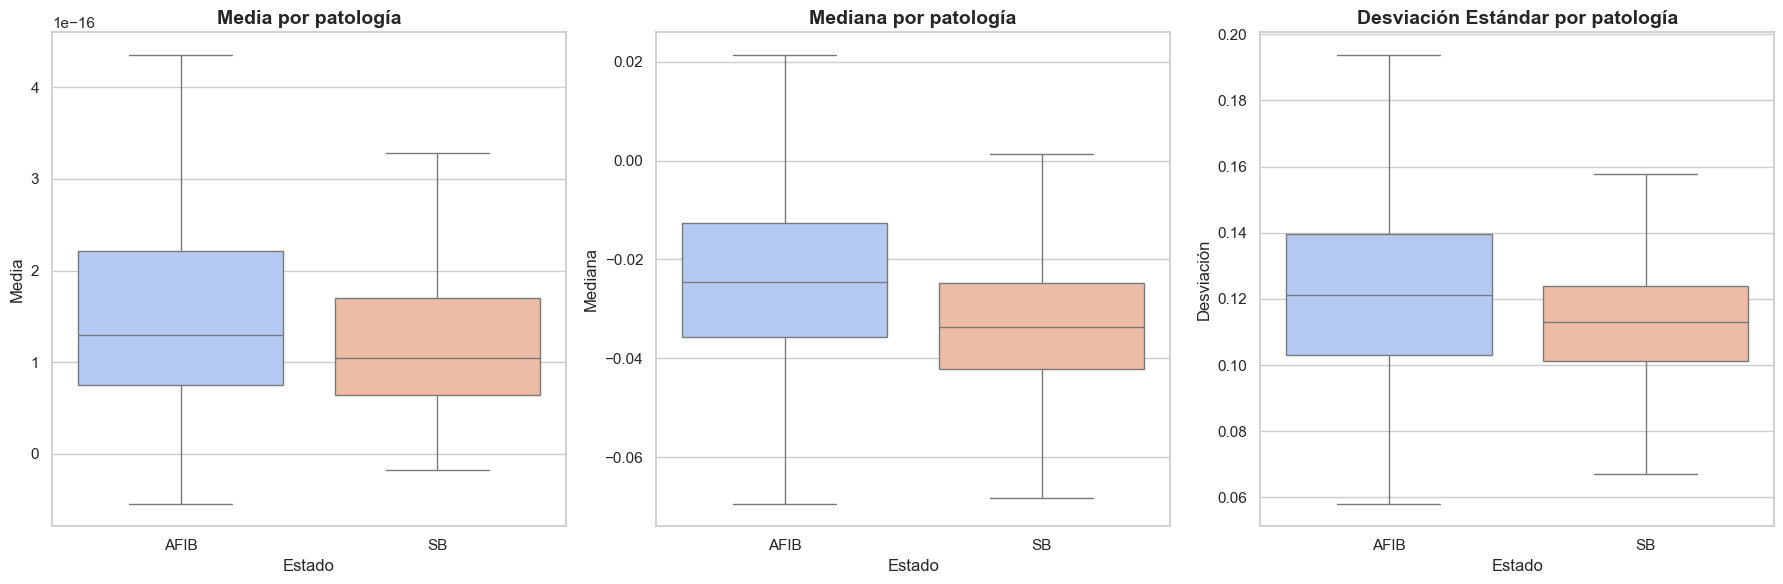

In [395]:
# Configurar el estilo y la paleta
sns.set(style="whitegrid")
palette = "coolwarm"  # Paleta de colores

# Crear subplots para las tres métricas
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Una fila, tres columnas

# Diagrama de cajas para la media
sns.boxplot(x='Estado', y='Media', data=stats_df, palette=palette, ax=axes[0],showfliers=False)
axes[0].set_title('Media por patología', fontsize=14, fontweight='bold')

# Diagrama de cajas para la mediana
sns.boxplot(x='Estado', y='Mediana', data=stats_df, palette=palette, ax=axes[1],showfliers=False)
axes[1].set_title('Mediana por patología', fontsize=14, fontweight='bold')

# Diagrama de cajas para la desviación estándar
sns.boxplot(x='Estado', y='Desviación', data=stats_df, palette=palette, ax=axes[2],showfliers=False)
axes[2].set_title('Desviación Estándar por patología', fontsize=14, fontweight='bold')

# Ajustar el layout para que no se solapen los títulos
plt.tight_layout()

# Mostrar los gráficos
plt.show()

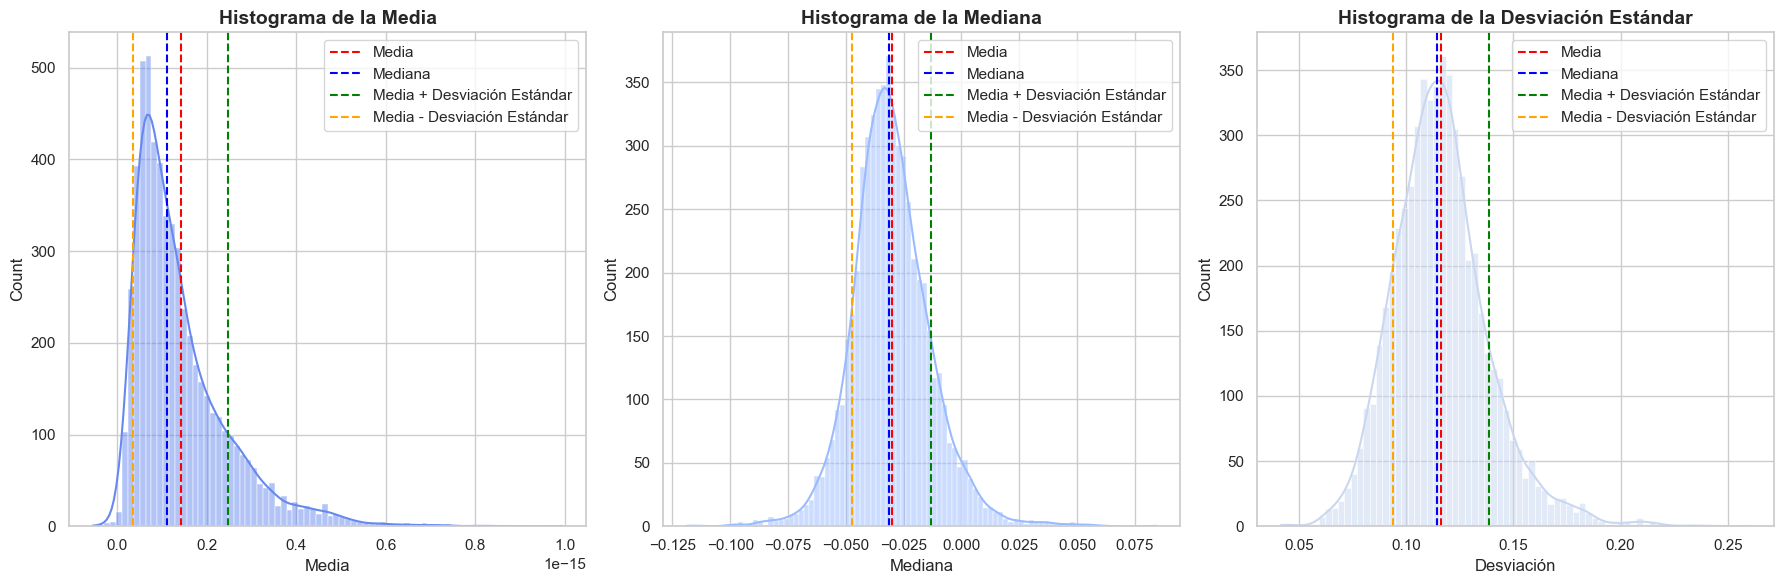

In [396]:
# Función ajustada para crear subplots de 1 fila y 3 columnas
def histplot_subplots(df, measures, titles):
    sns.set(style="whitegrid")  # Estilo de fondo blanco con grid
    palette = "coolwarm"  # Paleta de colores

    # Crear subplots de 1 fila y 3 columnas
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Iterar sobre las métricas
    for i, measure in enumerate(measures):
        # Histograma con KDE
        sns.histplot(df[measure].dropna(), kde=True, ax=axes[i], color=sns.color_palette(palette)[i])
        
        # Línea vertical en la media
        axes[i].axvline(np.mean(df[measure].dropna()), color='red', linestyle='--', label='Media')
        
        # Línea vertical en la mediana
        axes[i].axvline(np.median(df[measure].dropna()), color='blue', linestyle='--', label='Mediana')
        
        # Línea vertical en la desviación estándar
        std_dev = np.std(df[measure].dropna())
        mean = np.mean(df[measure].dropna())
        axes[i].axvline(mean + std_dev, color='green', linestyle='--', label='Media + Desviación Estándar')
        axes[i].axvline(mean - std_dev, color='orange', linestyle='--', label='Media - Desviación Estándar')

        # Título de cada gráfico
        axes[i].set_title(titles[i], fontsize=14, fontweight='bold')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

# Establecer las métricas y títulos
measures = ['Media', 'Mediana', 'Desviación']  # Columnas a graficar
titles = ['Histograma de la Media', 'Histograma de la Mediana', 'Histograma de la Desviación Estándar']  # Títulos de los gráficos

# Ejecutar la función de gráficos
histplot_subplots(stats_df, measures, titles)



<hr>

<h3><strong>Estadistica Inferencial para datos descriptivos</strong></h3>

* Prueba de normalidad y homocedasticidad

In [409]:
# Definir las métricas que deseas analizar
metrics = ['Media', 'Mediana', 'Desviación']  

# Inicializa una lista para almacenar los resultados
results = []

# Realiza pruebas para cada métrica
for metric in metrics:
    # Filtrar los datos para cada estado
    data_SB = stats_df[stats_df['Estado'] == 'SB'][metric].dropna()
    data_AFIB = stats_df[stats_df['Estado'] == 'AFIB'][metric].dropna()

    # Prueba de normalidad (Shapiro-Wilk)
    stat_normality_SB, p_value_normality_SB = stats.shapiro(data_SB)
    normality_result_SB = 'Normal' if p_value_normality_SB > 0.05 else 'No normal'

    stat_normality_AFIB, p_value_normality_AFIB = stats.shapiro(data_AFIB)
    normality_result_AFIB = 'Normal' if p_value_normality_AFIB > 0.05 else 'No normal'

    # Prueba de homocedasticidad (Levene)
    stat_homoscedasticity, p_value_homoscedasticity = stats.levene(data_SB, data_AFIB)
    homoscedasticity_result = 'Homocedástico' if p_value_homoscedasticity > 0.05 else 'Heterocedástico'

    # Agrega los resultados a la lista
    results.append({
        'Metric': metric,
        'SB Normality (p-value)': p_value_normality_SB,
        'SB Normality Result': normality_result_SB,
        'AFIB Normality (p-value)': p_value_normality_AFIB,
        'AFIB Normality Result': normality_result_AFIB,
        'Homoscedasticity (p-value)': p_value_homoscedasticity,
        'Homoscedasticity Result': homoscedasticity_result
    })

# Crea un DataFrame con los resultados
results_df_2 = pd.DataFrame(results)

# Muestra el DataFrame
results_df_2


,Metric,SB Normality (p-value),SB Normality Result,AFIB Normality (p-value),AFIB Normality Result,Homoscedasticity (p-value),Homoscedasticity Result
0,Media,2.029677e-52,No normal,2.634263e-35,No normal,8.062720e-18,Heterocedástico
1,Mediana,3.080074e-21,No normal,2.586992e-17,No normal,2.237689e-21,Heterocedástico
2,Desviación,2.738689e-27,No normal,7.456447e-10,No normal,5.819703e-75,Heterocedástico


* Prueba No parametrica - U de Mann-Whithney

In [401]:
# Definir las métricas que deseas analizar
metrics = ['Media', 'Mediana', 'Desviación']  # Asegúrate de que estas columnas existan en stats_df

# Inicializa una lista para almacenar los resultados
results = []

# Realiza la prueba para cada métrica
for metric in metrics:
    # Filtrar los datos para cada estado
    data_SB = stats_df[stats_df['Estado'] == 'SB'][metric].dropna()
    data_AFIB = stats_df[stats_df['Estado'] == 'AFIB'][metric].dropna()

    # Prueba U de Mann-Whitney
    u_statistic, p_value_mann_whitney = stats.mannwhitneyu(data_SB, data_AFIB, alternative='two-sided')

    # Determinar si hay una diferencia significativa
    significance = 'Hay Diferencia Significativa' if p_value_mann_whitney <= 0.05 else 'No hay diferencia significativa'

    # Agrega los resultados a la lista
    results.append({
        'Metric': metric,
        'Mann-Whitney U Statistic': u_statistic,
        'Mann-Whitney p-value': p_value_mann_whitney,
        'Significancia': significance
    })

# Crea un DataFrame con los resultados
results_df = pd.DataFrame(results)

# Muestra el DataFrame
results_df



,Metric,Mann-Whitney U Statistic,Mann-Whitney p-value,Significancia
0,Media,2909521.0,5.092374e-22,Hay Diferencia Significativa
1,Mediana,2335476.0,2.977447e-86,Hay Diferencia Significativa
2,Desviación,2748420.0,1.184388e-35,Hay Diferencia Significativa
